# 데이터 증식
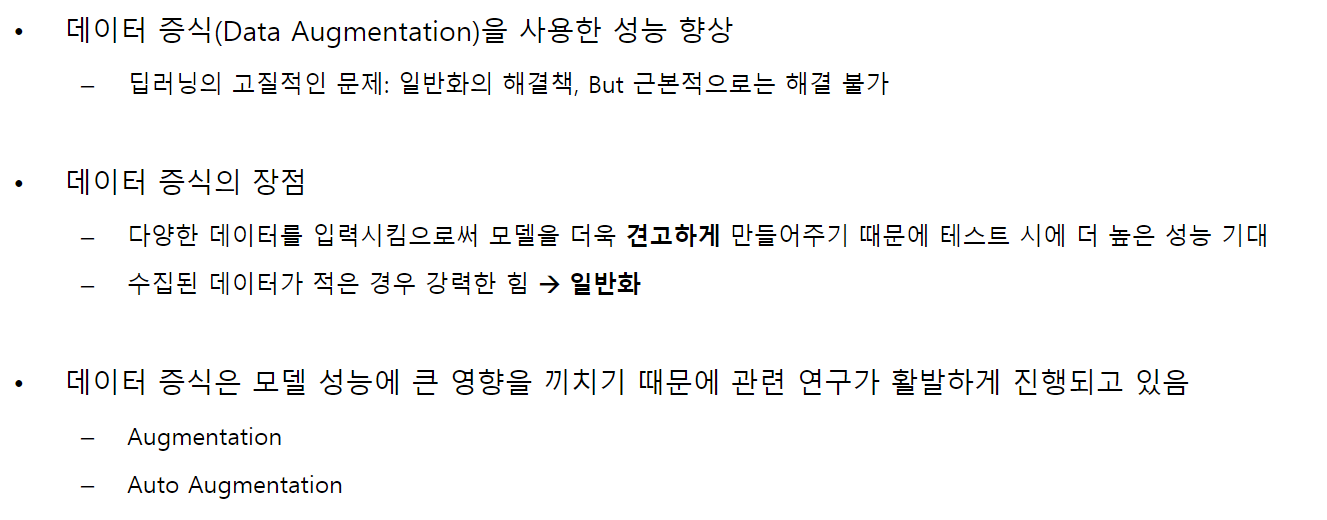

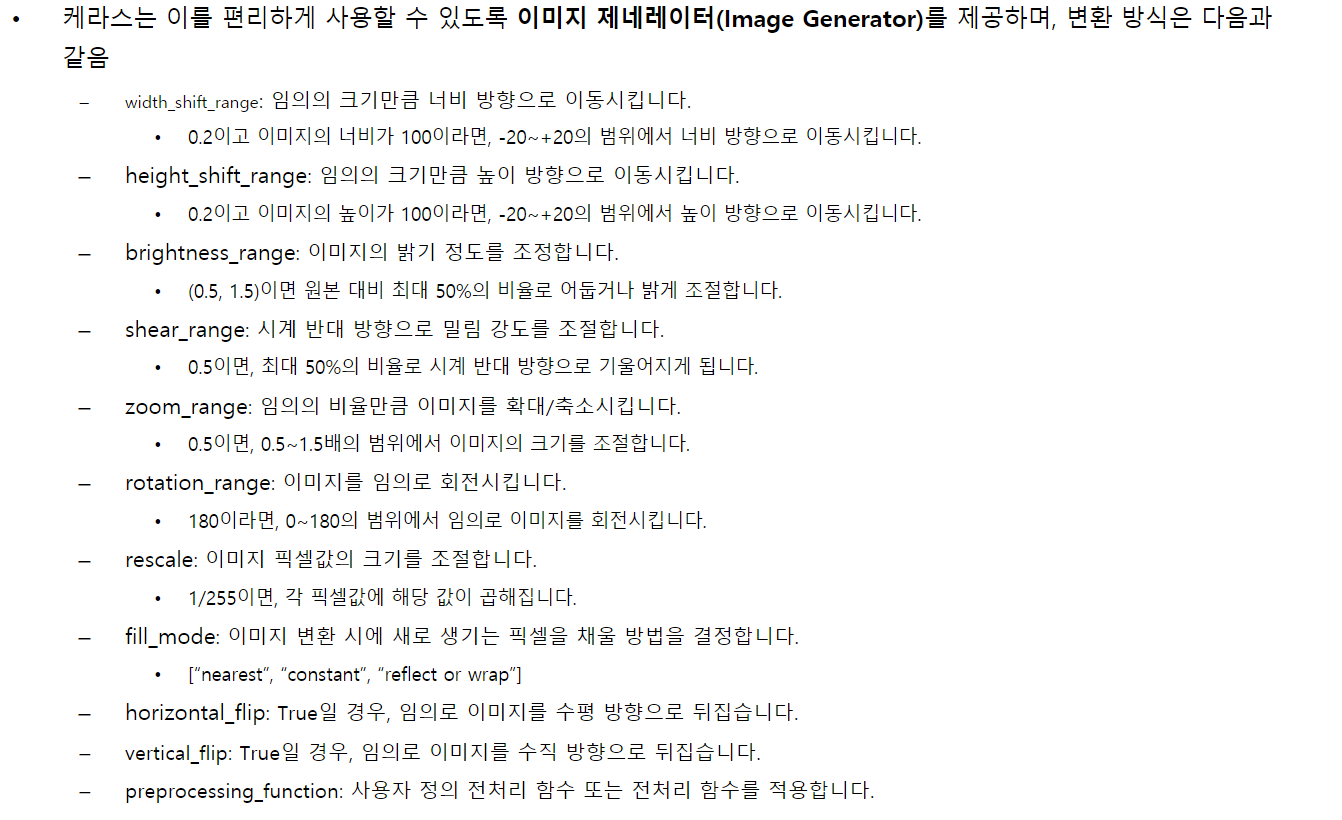

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------이미지 어그멘테이션
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   shear_range = 0.5,
                                   brightness_range = [0.5, 1.5],
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')
# fill_mode에는 'constant', 'nearest', 'reflect', 'wrap'
validation_datagen = ImageDataGenerator(rescale=1./255) 

### 이미지 제네레이터를 사용하여 이미지 그려보기

In [7]:
from google.colab import files
uploaded=files.upload()

Saving test_dog.jpg to test_dog.jpg


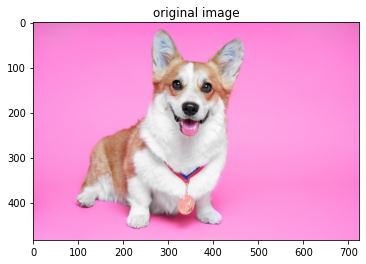

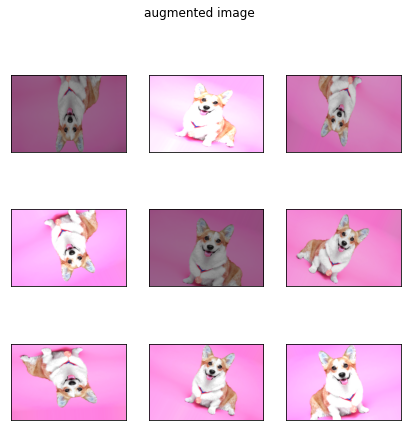

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt

# 이미지 사진을 불러옵니다.
test_image = img_to_array(load_img('/content/test_dog.jpg')).astype(np.uint8)
plt.figure()
plt.title('original image')
plt.imshow(test_image)

# 제네레이터를 사용해서 이미지를 변환합니다.
test_image = test_image.reshape((1, ) + test_image.shape)
train_generator = train_datagen.flow(test_image, batch_size = 1)

fig = plt.figure(figsize = (7, 7))
fig.suptitle('augmented image')

for i in range(9):
    data = next(train_generator) # 제네레이터에게서 이미지를 받아옵니다.
    image = data[0]
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(image, dtype = np.uint8))
    
plt.show()

## 데이터 증식 사용하여 학습하기

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 평균과 표준편차는 채널별로 구해줍니다.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3, random_state = 777)

# sparse_categorical_crossentropy를 사용하기 위해선 (batch_size, ) 형태를 가져야합니다.
# 따라서 np.squeeze를 사용해서 마지막 차원을 없애줍니다.
# y_train의 경우 (35000, 1) -> (35000, )이 됩니다.
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

170508288/170498071 [==============================] - 2s 0us/step


## 이미지 제네레이터를 사용하여 모델 학습하기

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest'
                                  )

# train_datagen = ImageDataGenerator(rescale=1./255,
                                  #  horizontal_flip = True,
                                  #  zoom_range = 0.2,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                  #  rotation_range = 30,
                                  #  fill_mode = 'nearest'
                                  # )

# 검증 데이터셋에는 변환을 사용하지 않습니다.
val_datagen = ImageDataGenerator()
# validation_datagen = ImageDataGenerator(rescale=1./255) 

batch_size = 32

train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size = batch_size)
val_generator = val_datagen.flow(x_val, y_val,
                                batch_size = batch_size)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', 
                 activation = 'relu', input_shape = (32, 32, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2)) # 드롭아웃을 추가합니다.

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2)) # 드롭아웃을 추가합니다.

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2)) # 드롭아웃을 추가합니다.

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)         

In [29]:
history = model.fit(train_generator,
                    epochs = 50,
                    batch_size = 32,
                    validation_data = val_generator)

Epoch 1/50
1094/1094 [==============================] - 22s 19ms/step - loss: 1.8552 - acc: 0.3181 - val_loss: 1.5312 - val_acc: 0.4402
Epoch 2/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.5875 - acc: 0.4263 - val_loss: 1.4400 - val_acc: 0.4781
Epoch 3/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.4624 - acc: 0.4760 - val_loss: 1.3072 - val_acc: 0.5287
Epoch 4/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.3832 - acc: 0.5055 - val_loss: 1.2538 - val_acc: 0.5505
Epoch 5/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.3130 - acc: 0.5304 - val_loss: 1.1482 - val_acc: 0.5896
Epoch 6/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.2561 - acc: 0.5525 - val_loss: 1.1265 - val_acc: 0.5909
Epoch 7/50
1094/1094 [==============================] - 21s 19ms/step - loss: 1.2148 - acc: 0.5681 - val_loss: 1.1183 - val_acc: 0.6046
Epoch 8/50
1094/1094 [==========================

## 학습 과정 그려보기

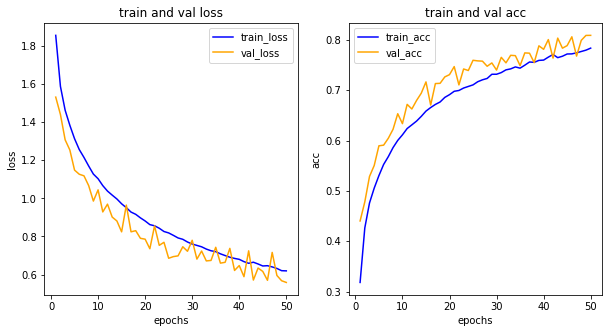

In [30]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## 배치정규화 층으로 학습해보기

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

history = model.fit(train_generator,
                    epochs = 50,
                    batch_size = 32,
                    validation_data = val_generator)

Epoch 1/50
1094/1094 [==============================] - 23s 20ms/step - loss: 1.6163 - acc: 0.4241 - val_loss: 1.3352 - val_acc: 0.5239
Epoch 2/50
1094/1094 [==============================] - 22s 20ms/step - loss: 1.3371 - acc: 0.5263 - val_loss: 1.1567 - val_acc: 0.5902
Epoch 3/50
1094/1094 [==============================] - 22s 20ms/step - loss: 1.2200 - acc: 0.5650 - val_loss: 1.2836 - val_acc: 0.5686
Epoch 4/50
1094/1094 [==============================] - 22s 20ms/step - loss: 1.1333 - acc: 0.5991 - val_loss: 1.0956 - val_acc: 0.6105
Epoch 5/50
1094/1094 [==============================] - 22s 20ms/step - loss: 1.0722 - acc: 0.6234 - val_loss: 1.1208 - val_acc: 0.6183
Epoch 6/50
1094/1094 [==============================] - 22s 20ms/step - loss: 1.0120 - acc: 0.6427 - val_loss: 0.9646 - val_acc: 0.6646
Epoch 7/50
1094/1094 [==============================] - 22s 20ms/step - loss: 0.9699 - acc: 0.6584 - val_loss: 0.9139 - val_acc: 0.6813
Epoch 8/50
1094/1094 [==========================

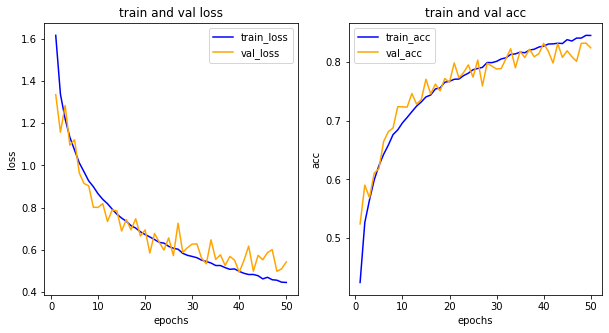

In [32]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()